### Efficient Partial Dependence Plots with decision trees

Both on [Nicolas Hug's post](https://nicolas-hug.com/blog/pdps) as well as on this [stackexchange discussion](https://stats.stackexchange.com/questions/236223/computing-partial-dependence-plots-for-trees) the instructions for computing PDP measures for trees efficiently follow Friedman's original instructions:

> For regression trees based on single-variable splits, however, the partial dependence of $f(X)$ on a specified target variable subset $X_S$  is straightforward to evaluate given only the tree, _without_ reference to the data itself. For a specific set of values for the variables $X_S$, a weighted traversal of the tree is performed. At the root of the tree, a weight value of $1$ is assigned. For each nonterminal node visited, if its split variable is in the target subset $X_S$, the appropriate left or right daughter node is visited and the weight is not modified. If the node’s split variable is a member of the complement subset $X_C$, then both daughters are visited and the current weight is multiplied by the fraction of training observations that went left or right, respectively, at that node.
>
>Each terminal node visited during the traversal is assigned the
current value of the weight. When the tree traversal is complete, the
value of $f_S(X_S)$ is the corresponding weighted average of the
$f(X)$ values over those terminal nodes visited during the tree
traversal.

In sklearn this is translated as follows:

> For each row in ``X`` a tree traversal is performed.
Each traversal starts from the root with weight 1.0.
>
>At each non-terminal node that splits on a target variable either
the left child or the right child is visited based on the feature
value of the current sample and the weight is not modified.
At each non-terminal node that splits on a complementary feature
both children are visited and the weight is multiplied by the fraction
of training samples which went to each child.
>
>At each terminal node the value of the node is multiplied by the
current weight (weights sum to 1 for all visited terminal nodes).


## Conditional versus Interventional

Both in his [paper](https://jerryfriedman.su.domains/ftp/trebst.pdf) and in the ESLII book, Friedman elaborates on how the **conditional** $E[f(x_S,X_C)|X_S=x_s]$ is different from the **interventional** $E[f(x_S,X_C)| \mathbf{do}(X_S=x_s)]$.

### Incorrect sklearn implementation?

I believe that the current sklearn implementation is in fact computing the **conditional** expectation $E[f(x_S,X_C)|X_S=x_s]$ !

In fact in both of the above recipes we should switch the roles of $X_S$ and $X_C$, i.e. visit both chidren of $X_S$.

I will use the Titanic data to illustrate the issues.
(This notebook can be found [here](https://github.com/markusloecher/markusloecher.github.io/blob/master/_posts/PDP_regression_trees.ipynb))

In [1]:
import seaborn
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.inspection import PartialDependenceDisplay, partial_dependence

Load the data

In [2]:
titanic = seaborn.load_dataset("titanic")
titanic["P1"] =  titanic["pclass"] == 1
X=titanic[["adult_male","P1"]]

In [3]:
# Create and fit the Decision Tree regressor
clf = DecisionTreeRegressor(max_depth=2)
clf.fit(X, titanic["survived"]);

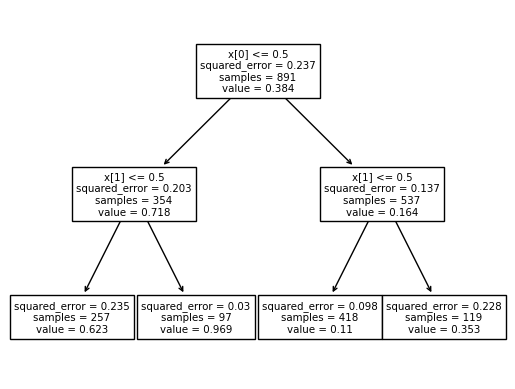

In [4]:
tree.plot_tree(clf)
plt.show()

The partial dependence on any feature can simply be computed via its definition:
$$\bar{f}_s(x_S) = \frac{1}{N}\sum_{i=1}^N{f(x_S,x^{(i)}_{C})}$$


Brute Force "by hand":

In [5]:
def my_pdp(X, features = ["adult_male", "P1"], vals = [False, True]):    
    pdp = {features[0] : np.zeros(2),features[1] : np.zeros(2)}
    
    for i, f in enumerate(features):
      for j, v in enumerate(vals):
        X_do = X.copy()#make a copy of the data
        X_do.iloc[:,i] = v
        pHat = clf.predict(X_do)
        pdp[f][j] = np.mean(pHat)
    #df = pd.DataFrame(pdp, index = vals, columns = vals)
    #df.index.set_names(features[0], inplace = True)
    #df.columns.set_names(features[1], inplace = True)  
    return pdp

my_pdp(X)

{'adult_male': array([0.70656908, 0.16893108]),
 'P1': array([0.31367542, 0.59773396])}

Full agreement with the partial dependence values computed by `partial_dependence` when we choose brute search:

In [9]:
features = ["adult_male", "P1"]
for f in features:
    pdp = partial_dependence(clf, X, f,method = "brute")
    print(f, pdp)

adult_male {'average': array([[0.70656908, 0.16893108]]), 'values': [array([False,  True])]}
P1 {'average': array([[0.31367542, 0.59773396]]), 'values': [array([False,  True])]}


But when we set `method = "recursion"` we obtain different answers, in fact we get $E[f(X_S,X_C)|X_S=x_s]$ which is simply the average prediction on the **subset**  of terminal nodes reached by the conditional data:

In [8]:
features = ["adult_male", "P1"]
for f in features:
    pdp = partial_dependence(clf, X, f,method = "recursion")
    print(f, pdp)


adult_male {'average': array([[0.71751412, 0.16387337]]), 'values': [array([False,  True])]}
P1 {'average': array([[0.31367542, 0.59773396]]), 'values': [array([False,  True])]}


## Correct Recursion

The following is a sketch of a recursive algorithm which would correctly compute the interventional PDP in **one** pass over the tree:



At the root of the tree, a weight value of $w=0$ is assigned. For each nonterminal node visited, if its split variable is in the complement subset $X_C$, the appropriate left or right daughter node is visited and the weight is not modified. If the node’s split variable is a member of the target subset $X_S$, then **both daughters** are visited and the corresponding number of (training) samples are added to the respective weight $w$.

Each terminal node visited during the traversal is assigned the
current value of the weight divived by the total number of observations. When the tree traversal is complete, the value of $f_S(X_S)$ is the corresponding weighted average of the $f(X)$ values over those terminal nodes visited during the tree
traversal.